**When run our project with existed trained weight, you can just run the box have (run), also make sure there is a folder called video1 (or video2 video3 ...) and in the video folder, there is a video1.mp4 (or video2.mp4 video3.mp4 ...), and three subfolder called video_frame, rect_frame and new_frame, you can see the example of the fomat in google drive project**

In [0]:
######### run ######### 
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
######### run #########
!pip install ipynb

# **Libs imported**(Run)

In [0]:
######### run ######### 
import cv2
import glob
import keras
from keras.utils import plot_model
from keras import backend as K
from keras.callbacks import *
from keras.models import *
from keras.layers import *
from keras.optimizers import *
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image
import os
import random
import numpy as np
from shapely.geometry.point import Point
import matplotlib.pyplot as plt
from google.colab.patches import cv2_imshow
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping

# **_for test**(No need to run)

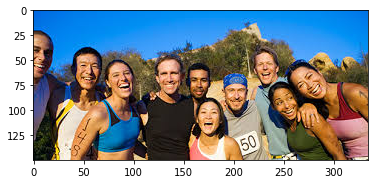

In [0]:
test_image = cv2.imread('/content/drive/My Drive/project/_test/download.jpeg')
test_image = cv2.cvtColor(test_image, cv2.COLOR_BGR2RGB)
plt.imshow(test_image)

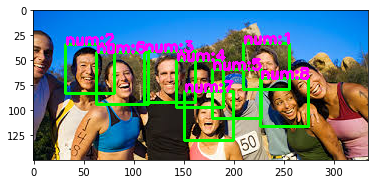

In [0]:
CASE_PATH = '/content/drive/My Drive/project/opencv/haarcascade_frontalface_default.xml'
color = (0, 255, 0)
face_cascade = cv2.CascadeClassifier(CASE_PATH)
gray = cv2.cvtColor(test_image, cv2.COLOR_BGR2GRAY)
faceRects = face_cascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=3, minSize=(20, 20))
result = test_image.copy()
if len(faceRects) > 0:          
  num = 0 
  for faceRect in faceRects:
      x, y, w, h = faceRect
      num += 1
      cv2.rectangle(result, (x - 10, y - 10), (x + w + 10, y + h + 10), color, 2)
      font = cv2.FONT_HERSHEY_SIMPLEX
      cv2.putText(result,'num:%d' % (num),(x-10, y-10), font, 0.5, (255,0,255), 2)
plt.imshow(result)

# **Some helper functions**(Run)

In [0]:
# adjust the size of the image
IMAGE_SIZE = 200
def resize_image(image, height=IMAGE_SIZE, width=IMAGE_SIZE):
    top, bottom, left, right = (0, 0, 0, 0)
    # get size of the image
    h, w = image.shape[:2]
    # find the longest side
    longest_edge = max(h, w)
    # find out how many pixel we need to make the height and width same
    if h < longest_edge:
        dh = longest_edge - h
        top = dh // 2
        bottom = dh - top
    elif w < longest_edge:
        dw = longest_edge - w
        left = dw // 2
        right = dw - left
    else:
        pass
    # rgb color
    color = [0, 0, 0]
    # add border to image
    constant = cv2.copyMakeBorder(image, top , bottom, left, right, cv2.BORDER_CONSTANT, value = color)
    # return adjusted image
    return cv2.resize(constant, (height, width))
  
  # Data augmentation
# shifting the image
def shift(img, scale):
  result = img
  # left
  if scale > 0:
    result = np.zeros(img.shape)
    result[:, :img.shape[1]-scale] = img[:, scale:]
  # right
  if scale < 0:
    result = np.zeros(img.shape)
    result[:, -scale:] = img[:, :scale]
  return result
    
# zoom the image
def zoom(img, scale):
  img = img
  if scale > 0:
    img = img[scale:img.shape[0]-scale, scale:img.shape[1]-scale]
  return img

# rotate the image
def rotate_img(img, angle):
  center = tuple(np.array(img.shape[1::-1]) / 2)
  rot_mat = cv2.getRotationMatrix2D(center, angle, 1.)
  result = cv2.warpAffine(img, rot_mat, img.shape[1::-1], flags=cv2.INTER_LINEAR)
  return result

# flip the image
def flip(img, way):
  img = img
  img = cv2.flip(img, way)
  return img

# **Capture video to frame**(Run)

In [0]:
def capture_video(path):
    captures = cv2.VideoCapture(path)
    c = 1
    while captures.isOpened():
        rval, frame = captures.read()
        if rval:
            cv2.imwrite(path[:-10] + 'video_frame/'+str('%06d'%c)+'.jpg',frame)
            c += 1
            cv2.waitKey(1)
        else:
          captures.release()
          return


In [0]:
# capture_video("/content/drive/My Drive/project/video1/video1.mp4")
# capture_video("/content/drive/My Drive/project/video2/video2.mp4")
capture_video("/content/drive/My Drive/project/video3/video3.mp4")
# capture_video("/content/drive/My Drive/project/video4/video4.mp4")

# **Prepare net work dataset** (No need to run)

datas[0] are images

datas[1] are lables

For every lable in datas[1], lable[0] is age, lable[1] is gender, lable[2] is race.

In [0]:
# img_path = './drive/My Drive/project/test1'
def get_data(dir_path, num=0):
  all_img_path = dir_path + '/*.jpg'
  img_path_list = glob.glob(all_img_path)
  datas = []
  if num == 0:
    num = len(img_path_list)
  for img_path in img_path_list:
    # age_l = [0] * 100
    # gender_l = [0] * 2
    # race_l = [0] * 5
    name = img_path[img_path.rfind('/') + 1:-4]
    age = int(name[:name.find('_')])
    gender = int(name[name.find('_') + 1:name.find('_') + 2])
    race = int(name[name.rfind('_') - 1:name.rfind('_')])
    # gender *= 100
    # race *= 20
    # gender_l[gender] = 1
    # race_l[race] = 1
    # age_l[age-1] = 1
    resized = resize_image(cv2.imread(img_path, cv2.COLOR_BGR2GRAY))
    # datas.append((resized[..., 0], (age, gender, race)))
    datas.append((resized[..., 0]/255., (gender, race, age)))
    num -= 1
    if num == 0:
      break
  return datas
# print(get_data(img_path)[0][0].shape)
# data = get_data(img_path)
# print(data[0][1])
# print(data)
# print(get_data(img_path)[0][0].shape)

In [0]:
# img_path = './drive/My Drive/project/test1'

def save_data(img_path, img_data_name, label_data_name, number):
  data = get_data(img_path, number)
  new_img_array = np.zeros((number, 200, 200))
  # new_label = 
  with open(label_data_name + '.txt', 'w') as f:
    for i in range(number):
      new_img_array[i] = data[i][0]
      new_item = data[i][1]
      f.write(str(new_item) +"\n")

  np.save(img_data_name + '.npy', new_img_array)

def load_data(img_data_name, label_data_name, num):
  labels = []
  with open(label_data_name + '.txt', "r") as f:
    for line in f:
      if num > 0:
        line_str = line.strip()
        gender = int(line_str[line_str.find('(') + 1:line_str.find(',')])
        race = int(line_str[line_str.find(',') + 1:line_str.rfind(',')])
        age = int(line_str[line_str.rfind(',') + 1:line_str.find(')')])
        labels.append((gender, race, age))
        num -= 1

  imgs = np.load(img_data_name + '.npy')
  return imgs, labels

# save_data(img_path, 'test1_data', 'test1_label', 13)
# imgs, labels  = load_data('test1_data', 'test1_label')
# print(len(imgs))
# print(len(labels))

In [0]:
tr_data_dir = './drive/My Drive/project/class_data/Training'
te_data_dir = './drive/My Drive/project/class_data/Test'
val_data_dir = './drive/My Drive/project/class_data/Validation'
# For saving image info to npy file.
# train_pair = get_data(tr_data_dir, 600)
# test_pair = get_data(te_data_dir, 200)
# val_pair = get_data(val_data_dir, 200)
# save_data(tr_data_dir, 'training_img', 'training_label', 13000)
# save_data(val_data_dir, 'valid_img', 'valid_label', 4600)
# save_data(te_data_dir, 'test_img', 'test_label', 4300)
# print (len(train_pair), len(test_pair), len(val_pair))

In [0]:
training_img, training_label = load_data('./drive/My Drive/project/class_data/training_img', './drive/My Drive/project/class_data/training_label', 13000)
valid_img, valid_label = load_data('./drive/My Drive/project/class_data/valid_img', './drive/My Drive/project/class_data/valid_label', 4600)
test_img, test_label = load_data('./drive/My Drive/project/class_data/test_img', './drive/My Drive/project/class_data/test_label', 4300)
print(test_img.shape)
print(len(test_label))

Generate data form we need to pass in Data Generator

In [0]:
def create_pair(imgs, labels, q=0):
  num = imgs.shape[0]
  datas = []
  if q == 0:
    q = num
  for i in range(q):
    img = imgs[i]
    label = labels[i]
    age_l = [0] * 100
    gender_l = [0] * 2
    race_l = [0] * 5
    gender_l[label[0]] = 1
    race_l[label[1]] = 1
    age_l[label[2]-1] = 1
    # datas.append((img, [gender_l, race_l, label[2]]))
    datas.append((img, [gender_l, race_l, age_l]))
  return datas
train_pair = create_pair(training_img, training_label)
test_pair = create_pair(test_img, test_label)
val_pair = create_pair(valid_img, valid_label)

In [0]:
print (len(train_pair), len(test_pair), len(val_pair))
print(train_pair[0][0])

13000 4300 4600
[[0.93333333 0.89019608 0.8627451  ... 0.70980392 0.73333333 0.76862745]
 [0.9254902  0.88235294 0.85490196 ... 0.71372549 0.7254902  0.75294118]
 [0.92156863 0.87843137 0.85098039 ... 0.72156863 0.72156863 0.73333333]
 ...
 [0.20392157 0.19215686 0.18431373 ... 0.9254902  0.93333333 0.93333333]
 [0.23137255 0.21176471 0.19607843 ... 0.9254902  0.93333333 0.93333333]
 [0.23137255 0.20784314 0.19215686 ... 0.9254902  0.93333333 0.93333333]]


# **Initial net**

In [0]:
# Generate the image and it's lable
class DataGenerator(keras.utils.Sequence):
    # Generates data for Keras
    def __init__(self, datas, batch_size=1, shuffle=True):
        self.batch_size = batch_size
        self.datas = datas
        self.indexes = np.arange(len(self.datas))
        self.shuffle = shuffle

    def __len__(self):
        # denotes the number of batches per epoch
        return int(np.floor(len(self.datas) / self.batch_size))

    def __getitem__(self, index):
        # Generate indexes of the batch
        batch_indexs = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
        # Find list of IDs
        batch_datas = [self.datas[k] for k in batch_indexs]
        # Generate data
        X, y = self.__data_generation(batch_datas)

        return X, y

    def on_epoch_end(self):
        # updates indexes after each epoch
        if self.shuffle == True:
            # print('inininininin')
            np.random.shuffle(self.indexes)

    def __data_generation(self, batch_datas):
      images = []
      labels = []
      for i, data in enumerate(batch_datas):
            image = data[0]
            image = np.expand_dims(image, axis=-1)
            # image = list(image)
            images.append(image)
            labels.append(data[1])
      # generates data containing batch_size samples
      return np.array(images), np.array(labels)

In [0]:
def class_net(loss, input_size=(200,200,1)):
  input = Input(input_size)
  # while we choose the initail weight, we can use 'he_normal' to choose from a Gaussian distribution with a standard
  # deviation of (2/N)^1/2, where N denotes the number of incoming nodes of one neuron.
  cov1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(input)
  # with Batch Normalization we can choose larger learning rate and use less drop out layer.
  cov1 = BatchNormalization()(cov1)
  cov1 = Activation('relu')(cov1)
  # print(cov1)
  cov1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(cov1)
  cov1 = BatchNormalization()(cov1)
  cov1 = Activation('relu')(cov1)
  down1 = MaxPooling2D(pool_size = 2)(cov1)
  # down1 = Dropout(0.25)(down1)
  cov2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(down1)
  cov2 = BatchNormalization()(cov2)
  cov2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(cov2)
  cov2 = BatchNormalization()(cov2)
  cov2 = Activation('relu')(cov2)
  down2 = MaxPooling2D(pool_size = 2)(cov2)
  # down2 = Dropout(0.25)(down2)
  cov3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(down2)
  cov3 = BatchNormalization()(cov3)
  cov3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(cov3)
  cov3 = BatchNormalization()(cov3)
  cov3 = Activation('relu')(cov3)
  down3 = MaxPooling2D(pool_size = 2)(cov3)
  cov = Conv2D(128, 3, activation = 'relu', padding='same', kernel_initializer = 'he_normal')(down3)
  cov = BatchNormalization()(cov)
  cov = Conv2D(128, 3, activation = 'relu', padding='same', kernel_initializer = 'he_normal')(cov)
  den = Flatten()(cov)
  den = Dropout(0.5)(den)
  den = Dense(256, activation='relu')(den)
  den = Dropout(0.5)(den)
  den = Dense(256, activation='relu')(den)
  den = Dropout(0.5)(den)
  output = Dense(107, activation='sigmoid')(den)
  model = Model(inputs = [input], outputs = [output])
  model.compile(optimizer = Adam(lr = 1e-4), 
                loss = loss, 
                metrics = ['accuracy'])
  # model.summary()
  return model

# **Ver1 net**

Neural network with 3 branches 

In [0]:
# Generate the image and it's lable
class DataGenerator(keras.utils.Sequence):
    # Generates data for Keras
    def __init__(self, datas, batch_size=1, shuffle=True, data_aug=True):
      self.batch_size = batch_size
      self.datas = datas
      self.indexes = np.arange(len(self.datas))
      self.shuffle = shuffle
      self.data_aug = data_aug

    def __len__(self):
      # denotes the number of batches per epoch
      return int(np.floor(len(self.datas) / self.batch_size))

    def __getitem__(self, index):
      # Generate indexes of the batch
      batch_indexs = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
      # Find list of IDs
      batch_datas = [self.datas[k] for k in batch_indexs]
      # Generate data
      X, y = self.__data_generation(batch_datas)

      return X, y
    
    def _data_arg(self, image):
      idx = random.randint(0, 4)
      imgs = [image]
      angle = random.randint(-50, 50)
      scale1 = random.randint(-50, 50)
      scale2 = random.randint(0, 50)
      way = random.randint(-1, 1)
      rotate_input = rotate_img(image, angle)
      shift_input = shift(image, scale1)
      flip_input = flip(image, way)
      zoom_input = zoom(image, scale2)
      imgs.extend([rotate_input, shift_input, flip_input, zoom_input])
      return imgs[idx]

    def on_epoch_end(self):
      # updates indexes after each epoch
      if self.shuffle == True:
          # print('inininininin')
          np.random.shuffle(self.indexes)

    def __data_generation(self, batch_datas):
      images = []
      # labels = []
      g = []
      r = []
      a = []
      for i, data in enumerate(batch_datas):
            image = data[0].copy()
            if self.data_aug == True:
              image = self._data_arg(image)
              image = resize_image(image)
            image = np.expand_dims(image, axis=-1)
            # image = list(image)
            images.append(image)
            g.append(data[1][0])
            r.append(data[1][1])
            a.append(data[1][2])
      # labels.append([g, r, a])
      # generates data containing batch_size samples
      return np.array(images), [np.array(g), np.array(r), np.array(a)]

In [0]:
def raceNet(input):
  cov1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(input)
  cov1 = BatchNormalization()(cov1)
  # cov1 = Activation('relu')(cov1)
  cov1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(cov1)
  cov1 = BatchNormalization()(cov1)
  # cov1 = Activation('relu')(cov1)
  down1 = MaxPooling2D(pool_size = 2)(cov1)
  down1 = Dropout(0)(down1)
  cov2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(down1)
  cov2 = BatchNormalization()(cov2)
  cov2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(cov2)
  cov2 = BatchNormalization()(cov2)
  # cov2 = Activation('relu')(cov2)
  down2 = MaxPooling2D(pool_size = 2)(cov2)
  down2 = Dropout(0)(down2)
  cov3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(down2)
  cov3 = BatchNormalization()(cov3)
  cov3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(cov3)
  cov3 = BatchNormalization()(cov3)
  # cov3 = Activation('relu')(cov3)
  down3 = MaxPooling2D(pool_size = 2)(cov3)
  down3 = Dropout(0.25)(down3)
  cov = Conv2D(128, 3, activation = 'relu', padding='same', kernel_initializer = 'he_normal')(down3)
  den = Flatten()(cov)
  den = BatchNormalization()(den)
  den = Dropout(0.5)(den)
  den = Dense(128, activation='relu')(den)
  den = BatchNormalization()(den)
  den = Dropout(0.5)(den)
  den = Dense(256, activation='relu')(den)
  den = Dropout(0)(den)
  output = Dense(5, activation='softmax')(den)
  return output
def ageNet(input):
  cov1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(input)
  cov1 = BatchNormalization()(cov1)
  # cov1 = Activation('relu')(cov1)
  cov1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(cov1)
  cov1 = BatchNormalization()(cov1)
  # cov1 = Activation('relu')(cov1)
  down1 = MaxPooling2D(pool_size = 2)(cov1)
  down1 = Dropout(0)(down1)
  cov2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(down1)
  cov2 = BatchNormalization()(cov2)
  cov2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(cov2)
  cov2 = BatchNormalization()(cov2)
  # cov2 = Activation('relu')(cov2)
  down2 = MaxPooling2D(pool_size = 2)(cov2)
  down2 = Dropout(0)(down2)
  cov3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(down2)
  cov3 = BatchNormalization()(cov3)
  cov3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(cov3)
  cov3 = BatchNormalization()(cov3)
  # cov3 = Activation('relu')(cov3)
  down3 = MaxPooling2D(pool_size = 2)(cov3)
  down3 = Dropout(0.25)(down3)
  cov = Conv2D(128, 3, activation = 'relu', padding='same', kernel_initializer = 'he_normal')(down3)
  den = Flatten()(cov)
  den = BatchNormalization()(den)
  den = Dropout(0.5)(den)
  den = Dense(128, activation='relu')(den)
  den = BatchNormalization()(den)
  den = Dropout(0.5)(den)
  den = Dense(256, activation='relu')(den)
  den = Dropout(0)(den)
  output = Dense(100, activation='softmax')(den)
  return output
def genderNet(input):
  cov1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(input)
  cov1 = BatchNormalization()(cov1)
  # cov1 = Activation('relu')(cov1)
  cov1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(cov1)
  cov1 = BatchNormalization()(cov1)
  # cov1 = Activation('relu')(cov1)
  down1 = MaxPooling2D(pool_size = 2)(cov1)
  down1 = Dropout(0)(down1)
  cov2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(down1)
  cov2 = BatchNormalization()(cov2)
  cov2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(cov2)
  cov2 = BatchNormalization()(cov2)
  # cov2 = Activation('relu')(cov2)
  down2 = MaxPooling2D(pool_size = 2)(cov2)
  down2 = Dropout(0)(down2)
  cov3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(down2)
  cov3 = BatchNormalization()(cov3)
  cov3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(cov3)
  cov3 = BatchNormalization()(cov3)
  # cov3 = Activation('relu')(cov3)
  down3 = MaxPooling2D(pool_size = 2)(cov3)
  down3 = Dropout(0.25)(down3)
  cov = Conv2D(128, 3, activation = 'relu', padding='same', kernel_initializer = 'he_normal')(down3)
  den = Flatten()(cov)
  den = BatchNormalization()(den)
  den = Dropout(0.5)(den)
  den = Dense(128, activation='relu')(den)
  den = BatchNormalization()(den)
  den = Dropout(0.5)(den)
  output = Dense(2, activation='softmax')(den)
  return output
def faceNet(loss, transfer=False, input_size=(200,200,1)):
  input = Input(input_size)
  gender = genderNet(input)
  race = raceNet(input)
  age = ageNet(input)
  model = Model(inputs = [input], outputs = [gender, race, age])
  #   for i,layer in enumerate(model.layers):
#     print(i,layer.name)
  if transfer:
    for layer in model.layers[:62]:
      layer.trainable=False
    for layer in model.layers[62:]:
      layer.trainable=True
  model.compile(optimizer = Adam(lr = 1e-4), 
                loss = loss, 
                # loss_weights =[2, 1.5, 1],
                metrics = ['accuracy'])
  # model.summary()
  # model.count_params()
  return model

# **Ver2 net**

Combine convolution layers of age and race together

In [0]:
# Generate the image and it's lable
class DataGenerator(keras.utils.Sequence):
    # Generates data for Keras
    def __init__(self, datas, batch_size=1, shuffle=True, data_aug=True):
      self.batch_size = batch_size
      self.datas = datas
      self.indexes = np.arange(len(self.datas))
      self.shuffle = shuffle
      self.data_aug = data_aug

    def __len__(self):
      # denotes the number of batches per epoch
      return int(np.floor(len(self.datas) / self.batch_size))

    def __getitem__(self, index):
      # Generate indexes of the batch
      batch_indexs = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
      # Find list of IDs
      batch_datas = [self.datas[k] for k in batch_indexs]
      # Generate data
      X, y = self.__data_generation(batch_datas)

      return X, y
    
    def _data_arg(self, image):
      idx = random.randint(0, 4)
      imgs = [image]
      angle = random.randint(-50, 50)
      scale1 = random.randint(-50, 50)
      scale2 = random.randint(0, 50)
      way = random.randint(-1, 1)
      rotate_input = rotate_img(image, angle)
      shift_input = shift(image, scale1)
      flip_input = flip(image, way)
      zoom_input = zoom(image, scale2)
      imgs.extend([rotate_input, shift_input, flip_input, zoom_input])
      return imgs[idx]

    def on_epoch_end(self):
      # updates indexes after each epoch
      if self.shuffle == True:
          # print('inininininin')
          np.random.shuffle(self.indexes)

    def __data_generation(self, batch_datas):
      images = []
      # labels = []
      g = []
      r = []
      a = []
      for i, data in enumerate(batch_datas):
            image = data[0].copy()
            if self.data_aug == True:
              image = self._data_arg(image)
              image = resize_image(image)
            image = np.expand_dims(image, axis=-1)
            # image = list(image)
            images.append(image)
            g.append(data[1][0])
            r.append(data[1][1])
            a.append(data[1][2])
      # labels.append([g, r, a])
      # generates data containing batch_size samples
      return np.array(images), [np.array(g), np.array(r), np.array(a)]

In [0]:
def raceNet(input):
  den = Flatten()(input)
  den = BatchNormalization()(den)
  den = Dropout(0.5)(den)
  den = Dense(128, activation='relu')(den)
  den = BatchNormalization()(den)
  den = Dropout(0)(den)
  den = Dense(256, activation='relu')(den)
  den = Dropout(0)(den)
  output = Dense(5, activation='softmax', name = 'race')(den)
  return output
def ageNet(input):
  den = Flatten()(input)
  den = BatchNormalization()(den)
  den = Dropout(0.5)(den)
  den = Dense(128, activation='relu')(den)
  den = BatchNormalization()(den)
  den = Dropout(0)(den)
  den = Dense(256, activation='relu')(den)
  den = Dropout(0.5)(den)
  output = Dense(100, activation='softmax', name = 'age')(den)
  return output
def genderNet(input):
  cov1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(input)
  cov1 = BatchNormalization()(cov1)
  # cov1 = Activation('relu')(cov1)
  cov1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(cov1)
  cov1 = BatchNormalization()(cov1)
  # cov1 = Activation('relu')(cov1)
  down1 = MaxPooling2D(pool_size = 2)(cov1)
  down1 = Dropout(0)(down1)
  cov2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(down1)
  cov2 = BatchNormalization()(cov2)
  cov2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(cov2)
  cov2 = BatchNormalization()(cov2)
  # cov2 = Activation('relu')(cov2)
  down2 = MaxPooling2D(pool_size = 2)(cov2)
  down2 = Dropout(0)(down2)
  cov3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(down2)
  cov3 = BatchNormalization()(cov3)
  cov3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(cov3)
  cov3 = BatchNormalization()(cov3)
  # cov3 = Activation('relu')(cov3)
  down3 = MaxPooling2D(pool_size = 2)(cov3)
  down3 = Dropout(0.25)(down3)
  # cov = Conv2D(128, 3, activation = 'relu', padding='same', kernel_initializer = 'he_normal')(down3)
  den = Flatten()(down3)
  den = BatchNormalization()(den)
  den = Dropout(0.5)(den)
  den = Dense(128, activation='relu')(den)
  den = BatchNormalization()(den)
  den = Dropout(0)(den)
  den = Dense(256, activation='relu')(den)
  den = Dropout(0.5)(den)
  output = Dense(2, activation='softmax', name = 'gender')(den)
  return output
def faceNet(loss, input_size=(200,200,1)):
  input = Input(input_size)
  cov1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(input)
  cov1 = BatchNormalization()(cov1)
  # cov1 = Activation('relu')(cov1)
  cov1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(cov1)
  cov1 = BatchNormalization()(cov1)
  # cov1 = Activation('relu')(cov1)
  down1 = MaxPooling2D(pool_size = 2)(cov1)
  down1 = Dropout(0)(down1)
  cov2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(down1)
  cov2 = BatchNormalization()(cov2)
  cov2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(cov2)
  cov2 = BatchNormalization()(cov2)
  # cov2 = Activation('relu')(cov2)
  down2 = MaxPooling2D(pool_size = 2)(cov2)
  down2 = Dropout(0)(down2)
  cov3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(down2)
  cov3 = BatchNormalization()(cov3)
  cov3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(cov3)
  cov3 = BatchNormalization()(cov3)
  # cov3 = Activation('relu')(cov3)
  down3 = MaxPooling2D(pool_size = 2)(cov3)
  down3 = Dropout(0.25)(down3)
  # cov = Conv2D(128, 3, activation = 'relu', padding='same', kernel_initializer = 'he_normal')(down3)
  gender = genderNet(input)
  race = raceNet(down3)
  age = ageNet(down3)
  model = Model(inputs = [input], outputs = [gender, race, age])
  model.compile(optimizer = Adam(lr = 1e-4), 
                loss = loss, 
                loss_weights =[1.5, 1.5, 1],
                metrics = ['accuracy'])
  # model.summary()
  # print('hi')
  # model.count_params()
  return model

# **Ver2 net takes rgb (run)**

Based on Ver2. This one takes rgb image as input

In [0]:
# Generate the image and it's lable
class DataGenerator(keras.utils.Sequence):
    # Generates data for Keras
    def __init__(self, datas, batch_size=1, shuffle=True, data_aug=True):
      self.batch_size = batch_size
      self.datas = datas
      self.indexes = np.arange(len(self.datas))
      self.shuffle = shuffle
      self.data_aug = data_aug

    def __len__(self):
      # denotes the number of batches per epoch
      return int(np.floor(len(self.datas) / self.batch_size))

    def __getitem__(self, index):
      # Generate indexes of the batch
      batch_indexs = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
      # Find list of IDs
      batch_datas = [self.datas[k] for k in batch_indexs]
      # Generate data
      X, y = self.__data_generation(batch_datas)

      return X, y
    
    def _data_arg(self, image):
      idx = random.randint(0, 4)
      imgs = [image]
      angle = random.randint(-50, 50)
      scale1 = random.randint(-50, 50)
      scale2 = random.randint(0, 50)
      way = random.randint(-1, 1)
      # print("index: "+ str(idx) + " angle: " + str(angle) + " shift: " + str(scale1) + " zoom: " + str(scale2))
      rotate_input = rotate_img(image, angle)
      shift_input = shift(image, scale1)
      flip_input = flip(image, way)
      zoom_input = zoom(image, scale2)
      imgs.extend([rotate_input, shift_input, flip_input, zoom_input])
      return imgs[idx]

    def on_epoch_end(self):
      # updates indexes after each epoch
      if self.shuffle == True:
          # print('inininininin')
          np.random.shuffle(self.indexes)

    def __data_generation(self, batch_datas):
      images = []
      # labels = []
      g = []
      r = []
      a = []
      for i, data in enumerate(batch_datas):
            image = data[0].copy()
            if self.data_aug == True:
              image = self._data_arg(image)
              image = resize_image(image)
            # image = np.expand_dims(image, axis=-1)
            # image = list(image)
            images.append(image/255.)
            g.append(data[1][0])
            r.append(data[1][1])
            a.append(data[1][2])
      # labels.append([g, r, a])
      # generates data containing batch_size samples
      return np.array(images), [np.array(g), np.array(r), np.array(a)]

In [0]:
def raceNet(input):
  den = Flatten()(input)
  # den = BatchNormalization()(den)
  den = Dropout(0.5)(den)
  den = Dense(128, activation='relu')(den)
  # den = BatchNormalization()(den)
  den = Dropout(0.5)(den)
  den = Dense(128, activation='relu')(den)
  den = Dropout(0)(den)
  output = Dense(5, activation='softmax', name='race')(den)
  return output
def ageNet(input):
  den = Flatten()(input)
  # den = BatchNormalization()(den)
  den = Dropout(0.5)(den)
  den = Dense(128, activation='relu')(den)
  # den = BatchNormalization()(den)
  den = Dropout(0.5)(den)
  den = Dense(256, activation='relu')(den)
  den = Dropout(0)(den)
  output = Dense(100, activation='softmax', name='age')(den)
  return output
def genderNet(input):
  cov1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(input)
  cov1 = BatchNormalization()(cov1)
  # cov1 = Activation('relu')(cov1)
  cov1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(cov1)
  cov1 = BatchNormalization()(cov1)
  # cov1 = Activation('relu')(cov1)
  down1 = MaxPooling2D(pool_size = 2)(cov1)
  down1 = Dropout(0)(down1)
  cov2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(down1)
  cov2 = BatchNormalization()(cov2)
  cov2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(cov2)
  cov2 = BatchNormalization()(cov2)
  # cov2 = Activation('relu')(cov2)
  down2 = MaxPooling2D(pool_size = 2)(cov2)
  down2 = Dropout(0)(down2)
  cov3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(down2)
  cov3 = BatchNormalization()(cov3)
  cov3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(cov3)
  cov3 = BatchNormalization()(cov3)
  # cov3 = Activation('relu')(cov3)
  down3 = MaxPooling2D(pool_size = 2)(cov3)
  down3 = Dropout(0.25)(down3)
  cov = Conv2D(128, 3, activation = 'relu', padding='same', kernel_initializer = 'he_normal')(down3)
  den = Flatten()(cov)
  # den = BatchNormalization()(den)
  den = Dropout(0.5)(den)
  den = Dense(128, activation='relu')(den)
  # den = BatchNormalization()(den)
  den = Dense(128, activation='relu')(den)
  den = Dropout(0)(den)
  output = Dense(2, activation='softmax', name='gender')(den)
  return output
def faceNet(loss, input_size=(200,200,3)):
  input = Input(input_size)
  cov1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(input)
  cov1 = BatchNormalization()(cov1)
  # cov1 = Activation('relu')(cov1)
  cov1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(cov1)
  cov1 = BatchNormalization()(cov1)
  # cov1 = Activation('relu')(cov1)
  down1 = MaxPooling2D(pool_size = 2)(cov1)
  down1 = Dropout(0)(down1)
  cov2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(down1)
  cov2 = BatchNormalization()(cov2)
  cov2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(cov2)
  cov2 = BatchNormalization()(cov2)
  # cov2 = Activation('relu')(cov2)
  down2 = MaxPooling2D(pool_size = 2)(cov2)
  down2 = Dropout(0)(down2)
  cov3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(down2)
  cov3 = BatchNormalization()(cov3)
  cov3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(cov3)
  cov3 = BatchNormalization()(cov3)
  # cov3 = Activation('relu')(cov3)
  down3 = MaxPooling2D(pool_size = 2)(cov3)
  down3 = Dropout(0.2)(down3)
  cov = Conv2D(128, 3, activation = 'relu', padding='same', kernel_initializer = 'he_normal')(down3)
  gender = genderNet(input)
  race = raceNet(cov)
  age = ageNet(cov)
  model = Model(inputs = [input], outputs = [gender, race, age])
  model.compile(optimizer = Adam(lr = 1e-4), 
                loss = loss, 
                loss_weights =[1, 1.5, 2],
                metrics = ['accuracy'])
  # model.summary()
  # model.count_params()
  return model

# **Ver2 rgb New**

This one is samilar with Ver2 rgb but with larger size

In [0]:
def raceNet(input):
  den = Flatten()(input)
  den = BatchNormalization()(den)
  den = Dropout(0.5)(den)
  den = Dense(128, activation='relu')(den)
  den = BatchNormalization()(den)
  den = Dropout(0)(den)
  den = Dense(256, activation='relu')(den)
  den = BatchNormalization()(den)
  den = Dropout(0.5)(den)
  output = Dense(5, activation='softmax', name='race')(den)
  return output
def ageNet(input):
  den = Flatten()(input)
  den = BatchNormalization()(den)
  den = Dropout(0.5)(den)
  den = Dense(128, activation='relu')(den)
  den = BatchNormalization()(den)
  den = Dropout(0)(den)
  den = Dense(256, activation='relu')(den)
  den = BatchNormalization()(den)
  den = Dropout(0.5)(den)
  output = Dense(100, activation='softmax', name='age')(den)
  return output
def genderNet(input):
  cov1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(input)
  cov1 = BatchNormalization()(cov1)
  # cov1 = Activation('relu')(cov1)
  cov1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(cov1)
  cov1 = BatchNormalization()(cov1)
  cov1 = Activation('relu')(cov1)
  down1 = MaxPooling2D(pool_size = 2)(cov1)
  down1 = Dropout(0)(down1)
  cov2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(down1)
  cov2 = BatchNormalization()(cov2)
  cov2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(cov2)
  cov2 = BatchNormalization()(cov2)
  cov2 = Activation('relu')(cov2)
  down2 = MaxPooling2D(pool_size = 2)(cov2)
  down2 = Dropout(0.25)(down2)
  cov3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(down2)
  cov3 = BatchNormalization()(cov3)
  cov3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(cov3)
  cov3 = BatchNormalization()(cov3)
  cov3 = Activation('relu')(cov3)
  down3 = MaxPooling2D(pool_size = 2)(cov3)
  down3 = Dropout(0.25)(down3)
  # cov = Conv2D(128, 3, activation = 'relu', padding='same', kernel_initializer = 'he_normal')(down3)
  den = Flatten()(down3)
  den = BatchNormalization()(den)
  den = Dropout(0.5)(den)
  den = Dense(128, activation='relu')(den)
  den = BatchNormalization()(den)
  den = Dropout(0)(den)
  den = Dense(256, activation='relu')(den)
  den = BatchNormalization()(den)
  den = Dropout(0.5)(den)
  output = Dense(2, activation='softmax', name='gender')(den)
  return output
def faceNet(loss, input_size=(200,200,3)):
  input = Input(input_size)
  cov1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(input)
  cov1 = BatchNormalization()(cov1)
  # cov1 = Activation('relu')(cov1)
  cov1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(cov1)
  cov1 = BatchNormalization()(cov1)
  cov1 = Activation('relu')(cov1)
  down1 = MaxPooling2D(pool_size = 2)(cov1)
  down1 = Dropout(0)(down1)
  cov2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(down1)
  cov2 = BatchNormalization()(cov2)
  cov2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(cov2)
  cov2 = BatchNormalization()(cov2)
  cov2 = Activation('relu')(cov2)
  down2 = MaxPooling2D(pool_size = 2)(cov2)
  down2 = Dropout(0.25)(down2)
  cov3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(down2)
  cov3 = BatchNormalization()(cov3)
  cov3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(cov3)
  cov3 = BatchNormalization()(cov3)
  cov3 = Activation('relu')(cov3)
  down3 = MaxPooling2D(pool_size = 2)(cov3)
  down3 = Dropout(0.25)(down3)
  # cov = Conv2D(128, 3, activation = 'relu', padding='same', kernel_initializer = 'he_normal')(down3)
  gender = genderNet(input)
  race = raceNet(down3)
  age = ageNet(down3)
  model = Model(inputs = [input], outputs = [gender, race, age])
  model.compile(optimizer = Adam(lr = 1e-4), 
                loss = loss, 
                loss_weights =[1, 1.5, 1],
                metrics = ['accuracy'])
  # model.summary()
  # model.count_params()
  return model

# **Ver3 net**

Changed age output form and use MSE to train it

In [0]:
# Generate the image and it's lable
class DataGenerator(keras.utils.Sequence):
    # Generates data for Keras
    def __init__(self, datas, batch_size=1, shuffle=True, data_aug=True):
      self.batch_size = batch_size
      self.datas = datas
      self.indexes = np.arange(len(self.datas))
      self.shuffle = shuffle
      self.data_aug = data_aug

    def __len__(self):
      # denotes the number of batches per epoch
      return int(np.floor(len(self.datas) / self.batch_size))

    def __getitem__(self, index):
      # Generate indexes of the batch
      batch_indexs = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
      # Find list of IDs
      batch_datas = [self.datas[k] for k in batch_indexs]
      # Generate data
      X, y = self.__data_generation(batch_datas)

      return X, y
    
    def _data_arg(self, image):
      idx = random.randint(0, 4)
      imgs = [image]
      angle = random.randint(-50, 50)
      scale1 = random.randint(-50, 50)
      scale2 = random.randint(0, 50)
      way = random.randint(-1, 1)
      # print("index: "+ str(idx) + " angle: " + str(angle) + " shift: " + str(scale1) + " zoom: " + str(scale2))
      rotate_input = rotate_img(image, angle)
      shift_input = shift(image, scale1)
      flip_input = flip(image, way)
      zoom_input = zoom(image, scale2)
      imgs.extend([rotate_input, shift_input, flip_input, zoom_input])
      return imgs[idx]

    def on_epoch_end(self):
      # updates indexes after each epoch
      if self.shuffle == True:
          # print('inininininin')
          np.random.shuffle(self.indexes)

    def __data_generation(self, batch_datas):
      images = []
      # labels = []
      g = []
      r = []
      a = []
      for i, data in enumerate(batch_datas):
            image = data[0].copy()
            if self.data_aug == True:
              image = self._data_arg(image)
              image = resize_image(image)
            # image = np.expand_dims(image, axis=-1)
            # image = list(image)
            images.append(image/255.)
            g.append(data[1][0])
            r.append(data[1][1])
            a.append(data[1][2]/100)
      # labels.append([g, r, a])
      # generates data containing batch_size samples
      return np.array(images), [np.array(g), np.array(r), np.array(a)]

In [0]:
def raceNet(input):
  den = Flatten()(input)
  den = BatchNormalization()(den)
  den = Dropout(0.5)(den)
  den = Dense(128, activation='relu')(den)
  den = BatchNormalization()(den)
  den = Dropout(0.5)(den)
  den = Dense(128, activation='relu')(den)
  den = Dropout(0.5)(den)
  output = Dense(5, activation='softmax', name='race')(den)
  return output
def ageNet(input):
  den = Flatten()(input)
  den = BatchNormalization()(den)
  den = Dropout(0.5)(den)
  den = Dense(128, activation='relu')(den)
  den = BatchNormalization()(den)
  den = Dropout(0.5)(den)
  den = Dense(256, activation='relu')(den)
  den = Dropout(0.5)(den)
  output = Dense(1, activation='sigmoid', name='age')(den)
  return output
def genderNet(input):
  cov1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(input)
  cov1 = BatchNormalization()(cov1)
  # cov1 = Activation('relu')(cov1)
  cov1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(cov1)
  cov1 = BatchNormalization()(cov1)
  # cov1 = Activation('relu')(cov1)
  down1 = MaxPooling2D(pool_size = 2)(cov1)
  down1 = Dropout(0.25)(down1)
  cov2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(down1)
  cov2 = BatchNormalization()(cov2)
  cov2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(cov2)
  cov2 = BatchNormalization()(cov2)
  # cov2 = Activation('relu')(cov2)
  down2 = MaxPooling2D(pool_size = 2)(cov2)
  down2 = Dropout(0.25)(down2)
  cov3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(down2)
  cov3 = BatchNormalization()(cov3)
  cov3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(cov3)
  cov3 = BatchNormalization()(cov3)
  # cov3 = Activation('relu')(cov3)
  down3 = MaxPooling2D(pool_size = 2)(cov3)
  down3 = Dropout(0.25)(down3)
  cov = Conv2D(128, 3, activation = 'relu', padding='same', kernel_initializer = 'he_normal')(down3)
  den = Flatten()(cov)
  # den = BatchNormalization()(den)
  den = Dropout(0.5)(den)
  den = Dense(128, activation='relu')(den)
  # den = BatchNormalization()(den)
  den = Dense(128, activation='relu')(den)
  den = Dropout(0.5)(den)
  output = Dense(2, activation='softmax', name='gender')(den)
  return output
def faceNet(loss, input_size=(200,200,3)):
  input = Input(input_size)
  cov1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(input)
  cov1 = BatchNormalization()(cov1)
  # cov1 = Activation('relu')(cov1)
  cov1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(cov1)
  cov1 = BatchNormalization()(cov1)
  # cov1 = Activation('relu')(cov1)
  down1 = MaxPooling2D(pool_size = 2)(cov1)
  down1 = Dropout(0.25)(down1)
  cov2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(down1)
  cov2 = BatchNormalization()(cov2)
  cov2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(cov2)
  cov2 = BatchNormalization()(cov2)
  # cov2 = Activation('relu')(cov2)
  down2 = MaxPooling2D(pool_size = 2)(cov2)
  down2 = Dropout(0.25)(down2)
  cov3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(down2)
  cov3 = BatchNormalization()(cov3)
  cov3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(cov3)
  cov3 = BatchNormalization()(cov3)
  # cov3 = Activation('relu')(cov3)
  down3 = MaxPooling2D(pool_size = 2)(cov3)
  down3 = Dropout(0.25)(down3)
  cov = Conv2D(128, 3, activation = 'relu', padding='same', kernel_initializer = 'he_normal')(down3)
  gender = genderNet(input)
  race = raceNet(cov)
  age = ageNet(cov)
  model = Model(inputs = [input], outputs = [gender, race, age])
  model.compile(optimizer = Adam(lr = 1e-4), 
                loss = loss, 
                loss_weights =[1, 1, 1],
                metrics = {'gender': 'accuracy', 'race': 'accuracy', 'age': 'mae'})
  # model.summary()
  # model.count_params()
  return model

# **Data Generator**(No need to run)

Test data generator

[array([[0, 1],
       [1, 0]]), array([[0, 1, 0, 0, 0],
       [0, 0, 1, 0, 0]]), array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])] (2, 200, 200, 1)
[array([[0, 1],
       [1, 0]]), array([[0, 1, 0, 0, 0],
       [0, 0, 1, 0, 0]]), array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

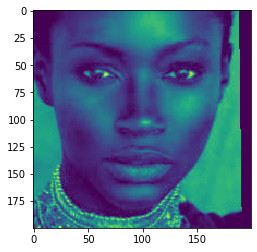

In [0]:
test = DataGenerator(val_pair, batch_size=2, data_aug=False)

imgs, lables = test.__getitem__(0)
print(lables, imgs.shape)
print(lables, imgs.shape)
plt.imshow(imgs[0][:,:,0]*255)
# i = cv2.cvtColor((imgs[0] * 255).astype('uint8'), cv2.COLOR_BGR2RGB)
# plt.imshow(i)
# plt.imshow(img)


# **Training**(Run the part with ############)

In [0]:
m = faceNet('categorical_crossentropy')
m.count_params()

############################# Run this cell #############################

In [0]:
################# RUN #############################
loss = ['categorical_crossentropy', 'categorical_crossentropy', 'categorical_crossentropy']
model = faceNet(loss=loss)
model.count_params()
ver1 = '/content/drive/My Drive/project/trained_weights/ver1.f5'
ver2 = '/content/drive/My Drive/project/trained_weights/ver2.f5'
ver2_new = '/content/drive/My Drive/project/trained_weights/ver2_new.f5'
ver2_rgb_new = "/content/drive/My Drive/project/trained_weights/ver2_rgb_new.f5"
ver2_rgb = '/content/drive/My Drive/project/trained_weights/ver2_rgb.f5'
ver3 = '/content/drive/My Drive/project/trained_weights/ver3.f5'
# According to the version of the net you choose
model.load_weights(ver2_rgb)

#################### no need to run below ###############

In [0]:
# start fitting.
# filepath='drive/My Drive/csc420/cat_data/model_{epoch:02d}-{loss:.2f}.hdf5'
# class_weight = '/content/drive/My Drive/project/trained_weights/class_weight.f5'
model_checkpoint = ModelCheckpoint(ver2_new, monitor='loss',verbose=1, save_best_only=True)
early_stopping = EarlyStopping(monitor='val_loss', patience=9999, verbose=2)
model.fit_generator(DataGenerator(train_pair, batch_size=20, data_aug=True), 
                steps_per_epoch=650,
                epochs=200,
                validation_data = DataGenerator(val_pair, data_aug=False),
                validation_steps=230,
                callbacks=[model_checkpoint, early_stopping]
               )

In [0]:
testGene = DataGenerator(test_pair, shuffle=False, data_aug=False)
# model = unet()
# model.load_weights(with_arg)
result = model.predict_generator(testGene, 4300 ,verbose=1)

For testing the prediction result

In [0]:
# print(len(result))
def test(n):
  t_g = [i for i, j in enumerate(test_pair[n][1][0]) if j == 1]
  # print(test_pair[n][1])
  t_r = [i for i, j in enumerate(test_pair[n][1][1]) if j == 1]
  t_a = [i for i, j in enumerate(test_pair[n][1][2]) if j == 1]
  print(t_g, t_r, t_a)
  gen = result[0][n]
  t3 = np.arange(2)
  gen = (gen * t3).sum()
  if gen >= 0.5 :
    gen = 1
  else:
    gen = 0
  rac = result[1][n]
  t2 = np.arange(5)
  rac = (rac * t2).sum()
  rac = round(rac)
  age = result[2][n]
  t = np.arange(100)
  age = (age * t).sum()
  print(gen, int(rac), int(round(age)))
  plt.imshow(test_pair[n][0])
def test_rgb(n):
  t_g = [i for i, j in enumerate(test_pair[n][1][0]) if j == 1]
  # print(test_pair[n][1])
  t_r = [i for i, j in enumerate(test_pair[n][1][1]) if j == 1]
  t_a = [i for i, j in enumerate(test_pair[n][1][2]) if j == 1]
  print(t_g, t_r, t_a)
  gen = result[0][n]
  t3 = np.arange(2)
  gen = (gen * t3).sum()
  if gen >= 0.5 :
    gen = 1
  else:
    gen = 0
  rac = result[1][n]
  t2 = np.arange(5)
  rac = (rac * t2).sum()
  rac = round(rac)
  age = result[2][n]
  t = np.arange(100)
  age = (age * t).sum()
  print(gen, int(rac), int(age))
  plt.imshow(cv2.cvtColor((test_pair[n][0]).astype('uint8'), cv2.COLOR_BGR2RGB))

In [0]:
# test(random.randint(0, 999))
test_rgb(random.randint(0, 199))



#**Detect face (run)** 

In [0]:
def predict_face(img):
    # img = cv2.imread(img_path, cv2.COLOR_BGR2GRAY)
    # img = resize_image(img[..., 0], IMAGE_SIZE, IMAGE_SIZE)
    # for RGB img input
    img = resize_image(img[:,:,:], IMAGE_SIZE, IMAGE_SIZE)

    age = [0] * 100
    # only for ver 3:  uncomment age = 0
    # age = 0

    gender = [0] * 2
    race = [0] * 5
    test_pair = [(img, [gender, race, age])]
    testGene = DataGenerator(test_pair, shuffle=False, data_aug=False)
    result = model.predict_generator(testGene, 1 ,verbose=1)
    gen = gen = result[0][0]
    t3 = np.arange(2)
    gen = (gen * t3).sum()
    if gen >= 0.5 :
      gen = 1
    else:
      gen = 0
    rac = result[1][0]
    t2 = np.arange(5)
    rac = (rac * t2).sum()
    age = result[2][0]
    # for other ver
    t = np.arange(100)
    age = (age * t).sum()
    # only for ver 3:  uncomment below two lines:
    # age = result[2][0][0] * 100
    # print(gen, int(round(rac)), int(round(age)))
    return (gen, int(round(rac)), int(round(age)))
# predict_face("/content/drive/My Drive/project/_test/download_0_39_42_34_34.jpg")

In [0]:
def face_information(prediction):
    result = ''
    gender, race, age = prediction[0], prediction[1], prediction[2]
    if gender == 0:
        result += "Male "
    else:
        result += "Female "
    if race == 0:
        result += "White "
    elif race == 1:
        result += "Black "
    elif race == 2:
        result += "Asian "
    elif race == 3:
        result += "Indian "
    else:
        result += "Others "
    if age <= 10:
        result += "Young "
    elif age > 10 and age <= 20:
        result += "Juvenile "
    elif age > 20 and age <= 30:
        result += "Younth "
    elif age > 30 and age <= 60:
        result += "Middle-aged "
    else:
        result += "Aged "
    # result += str(age)
    return result

In [0]:
def draw_rect(img_path):
    img = cv2.imread(img_path)
    classfier = cv2.CascadeClassifier(cv2.data.haarcascades + "haarcascade_frontalface_default.xml")
    grey = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    # v1
    # classfier = cv2.CascadeClassifier(cv2.data.haarcascades + "haarcascade_frontalface_alt2.xml")
    # faces = classfier.detectMultiScale(grey, scaleFactor = 1.2, minNeighbors = 5, minSize = (50, 50))
    # v2
    faces = classfier.detectMultiScale(grey, scaleFactor = 1.2, minNeighbors = 10, minSize = (62, 62))
    # v4
    # classfier = cv2.CascadeClassifier(cv2.data.haarcascades + "haarcascade_frontalface_default.xml")
    # faces = classfier.detectMultiScale(grey, scaleFactor = 1.1, minNeighbors = 10, minSize = (62, 62))
    color = (0, 255, 0)
    if len(faces) > 0:           
            i = 0
            for location in faces:
                x, y, w, h = location
                print(w,h)
                face = np.zeros((h, w, 3), np.uint8)
                face[:,:,:] = img[y:y+h,x:x+w,:]
                # n = "/content/drive/My Drive/000" + str(i) + ".jpg"
                # cv2.imwrite(n, face)  
                cv2.rectangle(img, (x - 1, y - 1), (x + w + 1, y + h + 1), color, 2)
                
                prediction = predict_face(face)
                info = face_information(prediction)
                text_color = (0,0,255)
                cv2.putText(img, info, (x - 100, y - 20),                     
                                cv2.FONT_HERSHEY_SIMPLEX,             
                                1, text_color, 2)  
                i += 1
    name = img_path[: -22] + "rect_frame/" + img_path[-10:]
    # name = "/content/drive/My Drive/rect_frame/"+ img_path[-10:]
    cv2.imwrite(name, img)    
    plt.imshow(img)


125 125
1/1 [==============================] - 0s 45ms/step
[[1.0000000e+00 2.6445312e-08]]
0 0 36
136 136
1/1 [==============================] - 0s 44ms/step
[[1.60247e-15 1.00000e+00]]
1 0 33


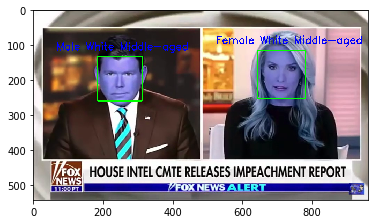

In [0]:
# for test the function draw_rect
draw_rect("/content/drive/My Drive/project/video3/video_frame/000146.jpg")
# draw_rect("/content/drive/My Drive/video_frame/000101.jpg")

In [0]:
def draw_all_rect_frame(path):
    # path = '/content/drive/My Drive/project/video/video_frame/' 
    filelist = os.listdir(path)
    filelist.sort()
    # c = 0
    for item in filelist:
        if item.endswith('.jpg'):
          # if c < 30:
            img_path = path + item
            print(img_path)
            draw_rect(img_path)
            # c += 1

# path = '/content/drive/My Drive/project/video1/video_frame/' 
# path = '/content/drive/My Drive/project/video2/video_frame/' 
path = '/content/drive/My Drive/project/video3/video_frame/' 
# path = '/content/drive/My Drive/project/video4/video_frame/' 
draw_all_rect_frame(path)

# **Swap face (run)**

In [0]:
def swap_face(img_path, face_path, gender, race, age):
    img = cv2.imread(img_path)
    new_face = cv2.imread(face_path)
    classfier = cv2.CascadeClassifier(cv2.data.haarcascades + "haarcascade_frontalface_alt2.xml")
    grey = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = classfier.detectMultiScale(grey, scaleFactor = 1.1, minNeighbors = 5, minSize = (10, 10))
    # v2:
    classfier = cv2.CascadeClassifier(cv2.data.haarcascades + "haarcascade_frontalface_default.xml")
    faces = classfier.detectMultiScale(grey, scaleFactor = 1.2, minNeighbors = 10, minSize = (62, 62))
    color = (0, 255, 0)
    if len(faces) > 0:
            i = 0
            for location in faces:  
                x, y, w, h = location
                face = np.zeros((h, w, 3), np.uint8)
                face[:,:,:] = img[y:y+h,x:x+w,:]
                prediction = predict_face(face)
                info = face_information(prediction)
                print((race in info or not race))
                flag = (gender in info or not gender) and (race in info or not race) and (age in info or not age)
                # print(i)
                if flag:
                    size = (w, h)
                    new_face = cv2.resize(new_face, size, interpolation = cv2.INTER_CUBIC)
                    # ratio of background image
                    # v1
                    # h_l = int(0 * h)
                    # h_r = int(0.9 * h)
                    # w_l = int(0.05 * w)
                    # w_r = int(0.9 * w)
                    # v2
                    # h_l = int(0 * h)
                    # h_r = int(0.95 * h)
                    # w_l = int(0.05 * w)
                    # w_r = int(0.9 * w)
                    # v3
                    h_l = int(0 * h)
                    h_r = int(1 * h)
                    w_l = int(0.05 * w)
                    w_r = int(0.95 * w)
                    # ratio of face image
                    f_h_l = int(0.2 * h)
                    f_h_r = int(0.8 * h)
                    f_w_l = int(0.2 * w)
                    f_w_r = int(0.8 * w)
                    # v3
                    f_h_l = int(0.2 * h)
                    f_h_r = int(0.8 * h)
                    f_w_l = int(0.2 * w)
                    f_w_r = int(0.8 * w)
                    obj = new_face[f_h_l:f_h_r,f_w_l:f_w_r,:]
                    obj = cv2.resize(obj, (w_r-w_l, h_r-h_l), interpolation = cv2.INTER_CUBIC)
                    background = img[y+h_l:y+h_r,x+w_l:x+w_r,:]
                    swaped = merge_edge(obj, background)

                    img[y+h_l:y+h_r,x+w_l:x+w_r,:] = swaped[:,:,:]

                    i += 1

    name = img_path[: -22] + "new_frame/" + img_path[-10:]  
    # for saving test sample img 
    # name = "/content/drive/My Drive/project/video/new_frame/" + img_path[-10:]
    # name = "/content/drive/My Drive/00" + img_path[-10:]
    cv2.imwrite(name, img)
    # # test
    plt.imshow(img)

1/1 [==============================] - 0s 45ms/step
[[9.9998939e-01 1.0576339e-05]]
0 0 21
True


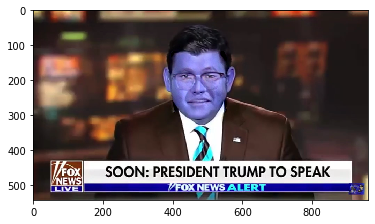

In [0]:
# just for test:
path = "/content/drive/My Drive/project/video3/video_frame/000050.jpg"
face_path = "/content/drive/My Drive/project/video1/face.jpg"
swap_face(path, face_path, "Male", "", "")

In [0]:
def merge_edge(obj, background):

    mask = 255 * np.ones(obj.shape, obj.dtype)
    width, height = obj.shape[0], obj.shape[1]
    center = (int(height/2), int(width/2))
    # clone = cv2.seamlessClone(obj, background, mask, center, cv2.NORMAL_CLONE)
    clone = cv2.seamlessClone(obj, background, mask, center, cv2.MIXED_CLONE)

    return clone

In [0]:
# test function swap_face

# face_path = "/content/drive/My Drive/project/video/face.jpg"
face_path = "/content/drive/My Drive/download_1_118_50_36_36.jpg"
swap_face("/content/drive/My Drive/video_frame/000011.jpg", face_path,  "", "", "")

In [0]:
def swap_all_faces(path, face_path, gender, race, age):
    # path = '/content/drive/My Drive/project/video/video_frame/' 
    filelist = os.listdir(path)
    c = 0
    for item in filelist:
        if item.endswith('.jpg'):
            # if c > 50:
            #   return
            img_path = path + item
            print(img_path)
            # face_path = "/content/drive/My Drive/download_1_118_50_36_36.jpg"
            swap_face(img_path, face_path,  gender, race, age)
            # c += 1

# path = '/content/drive/My Drive/project/video1/video_frame/' 
face_path = "/content/drive/My Drive/project/video1/face.jpg"

# path = '/content/drive/My Drive/project/video2/video_frame/' 
face_path = "/content/drive/My Drive/project/video3/face.jpg"
path = '/content/drive/My Drive/project/video3/video_frame/'
gender, race, age = "Male", "White", ""

# face_path = "/content/drive/My Drive/project/video3/face2.jpg"

swap_all_faces(path, face_path, gender, race, age)

# **Save new video (run)**

In [0]:
def save_new_vedio(mode, num):
    # path = '/content/drive/My Drive/_frame/' 
    if mode == "detect":
        path = '/content/drive/My Drive/project/video' + str(num) + '/rect_frame/' 
        new_name = '/content/drive/My Drive/project/video' + str(num) + '/detect_video.avi' 
    else:
        path = '/content/drive/My Drive/project/video' + str(num) + '/new_frame/' 
        new_name = '/content/drive/My Drive/project/video' + str(num) + '/swap_video.avi' 
    filelist = os.listdir(path)
    filelist.sort()
    temp = cv2.imread('/content/drive/My Drive/project/video' + str(num) + '/video_frame/000001.jpg')
    size = (temp.shape[1], temp.shape[0])
    # print(size)
    fps = 25 
    video = cv2.VideoWriter(new_name, cv2.VideoWriter_fourcc('I', '4', '2', '0'), fps, size)
    # video = cv2.VideoWriter("/content/drive/My Drive/11result.mp4", cv2.VideoWriter_fourcc('M', 'J', 'P', 'G'), fps, size)

    for item in filelist:
        if item.endswith(".jpg"):
            img_path = path + item
            img = cv2.imread(img_path)
            print(img_path)
            video.write(img)
 
    video.release()
    cv2.destroyAllWindows()

In [0]:
# num = 1
# num = 2
num = 3
# num = 4

# change for save detect/swap video
save_new_vedio("detect", num)
# save_new_vedio("swap", num)